In [1]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy import stats, integrate

import matplotlib.pyplot  as plt

from matplotlib.ticker import FormatStrFormatter # to set the format of the plot's axis

import os
import math
import tables as tb

# Functions

In [2]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    return a*stats.norm.pdf(x, mu, sigma) 

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)

def EL_yield(E, p, d):
    # E[kV/cm] electric field 
    # p[bar] pressure
    # d[cm] verage absorption depth
    return (140*E/p - 116)*d*p # [photons/e⁻]


# Global parameters

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 20)

In [4]:
# plt.rcParams["figure.figsize"] = 10, 8
# plt.rcParams["font.size"] = 10

In [5]:
event_id = 56

dt = 1e3 # [ns] = 1us

v_d = 967.99*1e-6 # [mm/ns] = 967.99 [um/us] Drift velocity
Xe_ion = 11.14*1e-6 # [MeV] Xe ionization potential


d = 0.5 # [cm] verage absorption depth (https://arxiv.org/pdf/1202.0721.pdf)
p = 1.52 # [bar] pressure
E = 3*p # [kV/cm] electric field (we ussually get E/p, so we define E in terms of p) (https://arxiv.org/pdf/1202.0721.pdf)
V = E*d # [kV] voltage

# EL_gain = 75 # [photons/e⁻] optical gain (https://iopscience.iop.org/article/10.1088/1748-0221/10/03/P03025/pdf)
# EL_gain = 700 # [photons/e⁻] optical gain (Francesc)
EL_gain = 2500 # [photons/e⁻] optical gain (https://arxiv.org/pdf/1202.0721.pdf)
# EL_gain = EL_yield(E, p, d) # [photons/e⁻] optical gain (https://arxiv.org/pdf/physics/0702142.pdf)
# EL_gain = 140*V # [photons/e⁻] optical gain (https://arxiv.org/pdf/physics/0702142.pdf)
print('EL_gain = ', EL_gain)

e_lt = 16e5 # electron lifetime
recombi = 0.026 # recombination factor (https://iopscience.iop.org/article/10.1088/1748-0221/10/03/P03025/pdf)

z_max = 1.5e3 # [mm] Detector length/2
z_min = -z_max # symmetric detector

EL_gain =  2500


# Data

## Units are fundamental units used in Geant4, ie:

### Length [L]: mm (milimeter)
### Time [T]: ns (nanosecond)
### Energy [E]: MeV (megaelectronvolt)


In [6]:
path = '/home/investigator/mariandbt/nexus/'

filename = os.path.join(path, "Xe_tank_bb0nu.next.h5")

In [7]:
# inside a .h5 file there are several objects, let's see which data-set (dst) we want
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/nexus/Xe_tank_bb0nu.next.h5 (File) ''
Last modif.: '2023-03-27T15:22:22+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(36,)) ''
/MC/hits (Table(1499311,)) ''
/MC/particles (Table(317632,)) ''
/MC/sns_positions (Table(0,)) ''
/MC/sns_response (Table(0,)) ''



In [8]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
dst = pd.read_hdf(filename, "/MC/hits")
# dst = pd.read_hdf(filename, "/MC/hits").groupby("event_id").get_group(event_id)

In [9]:
dst['time'].min()

3.2897918345042854e-07

# Electron distribution on time

### Number of events

In [10]:
# n_events = dst['event_id'].max() + 1
n_events = len(dst['event_id'].unique())
n_events

10000

### Total time = initial time + drift time

In [11]:
drift_time = (z_max - dst['z'])/(v_d) # [ns]
dst['drift_time'] = drift_time
dst['tot_time'] = dst['time'] + drift_time
# dst = dst.sort_values(by = ['tot_time'])

### Number of electrons = (energy deposition) * (EL gain) * (1 - recombination factor) * (lifetime factor)/ (ionization energy Xe)

In [12]:
n_e = np.floor(dst['energy']*EL_gain*(1 - recombi)*np.exp(-dst['drift_time']/e_lt)/Xe_ion)
dst['n_e'] = n_e

In [13]:
dst['event_id'].max(), len(dst['event_id'].unique()), len(dst['n_e']), dst['n_e'].sum()

(9999, 10000, 1499311, 2248100902081.0)

In [14]:
# %%timeit
s2 = []

# for ii in range(1000):
for ii in range(n_events):

    dst_event = dst.loc[(dst['event_id'] == ii), :] # faster
#     dst_event = dst.groupby("event_id").get_group(ii) # slower
    
    if (dst_event['tot_time'].max() - dst_event['tot_time'].min()) > dt:
        hist_bins = np.arange(dst_event['tot_time'].min(), dst_event['tot_time'].max(), dt)
    else:
        hist_bins = np.array([dst_event['tot_time'].min(), dst_event['tot_time'].max()])
        
    hist_weights = dst_event['n_e']
    events, bins = np.histogram(dst_event['tot_time'], hist_bins, weights = hist_weights);

    s2.append(events.max())
    
s2 = np.array(s2)

In [15]:
s2.mean()

37870777.8032

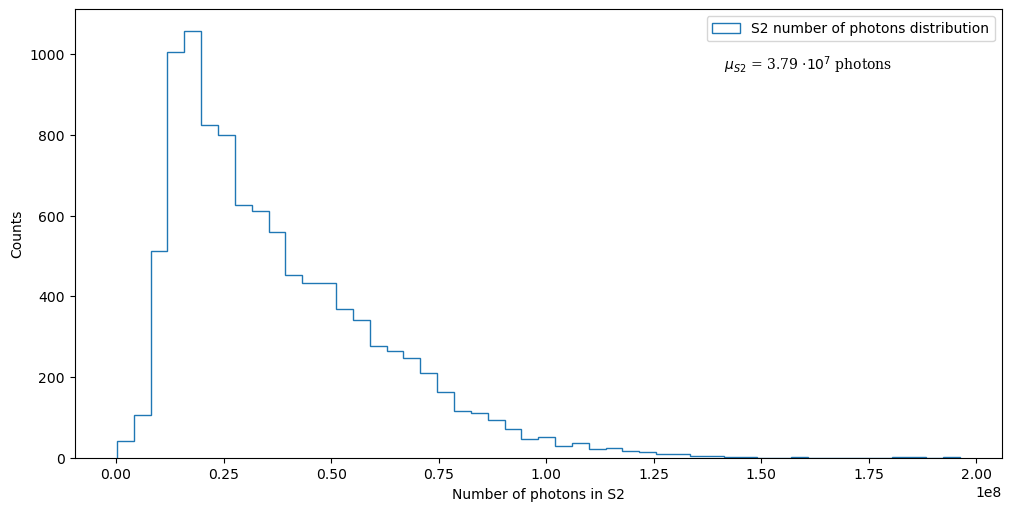

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

#_________plot_settings_________________________________________________

events, bins, bars = ax.hist(s2, 50, density=False, 
                             label='S2 number of photons distribution', histtype='step')
    
x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

# # gaussian fit
# # popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, bounds=([0, 1e5, 1e4], [np.inf, 3e6, 1e6])) 
# # popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, (bins[:-1]*events).mean(), 1e6]) 
# popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, s2.mean(), 1e5]) 

# a, mu, sigma = popt
# best_fit_line = gauss(x_ax, a, mu, sigma)

# ax.plot(x_ax, gauss(x_ax, a, mu, sigma), '-', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu, sigma))

ax.text(0.7, .9, '$\mu_{S2}$ = %.2f $\cdot 10^{7}$ photons'%(s2.mean()*1e-7), transform=ax.transAxes, fontsize=10, verticalalignment='top', 
# ax.text(0.7, .9, '$\mu_{S2}$ = %.2f '%(s2.mean()), transform=ax.transAxes, fontsize=10, verticalalignment='top', 
        fontfamily='serif', bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

ax.set_xlabel('Number of photons in S2');
ax.set_ylabel('Counts');
ax.legend(fontsize=10, loc='best')